In [2]:
# Librerias:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt
import torchvision.transforms.functional as TF
from tqdm import tqdm
import random
from scipy.ndimage import map_coordinates, gaussian_filter

In [3]:
import os
import numpy as np



base_path = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    if "train_imgs.npy" in filenames:
        base_path = dirname
        
        break

if base_path == "":
    print("❌ ERROR: No encuentro los archivos. Asegúrate de haberle dado a 'Add Input' y subirlos.")
else:
    # 2. Definir las rutas usando la base que encontramos
    train_imgs_path = os.path.join(base_path, "train_imgs.npy")
    train_annot_path = os.path.join(base_path, "train_annot.npy")

    val_imgs_path = os.path.join(base_path, "val_imgs.npy")
    val_annot_path = os.path.join(base_path, "val_annot.npy")

    test_imgs_path = os.path.join(base_path, "test_imgs.npy")
    test_annot_path = os.path.join(base_path, "test_annot.npy")

    # 3. Cargar los datos
    print("Cargando datos...")
    train_imgs = np.load(train_imgs_path)
    train_masks = np.load(train_annot_path)

    val_imgs = np.load(val_imgs_path)
    val_masks = np.load(val_annot_path)

    test_imgs = np.load(test_imgs_path)
    test_masks = np.load(test_annot_path)

    # 4. Filtrar máscaras (tu lógica original)
    train_masks = np.where(train_masks == 2, 0, train_masks)
    val_masks = np.where(val_masks == 2, 0, val_masks)
    test_masks = np.where(test_masks == 2, 0, test_masks)

    # Verificación
    print("Train images shape:", train_imgs.shape)
    print("Train masks shape:", train_masks.shape)
    print("Validation images shape:", val_imgs.shape)
    print("Validation masks shape:", val_masks.shape)
    print("Test images shape:", test_imgs.shape)
    print("Test masks shape:", test_masks.shape)

Cargando datos...
Train images shape: (4564, 256, 256)
Train masks shape: (4564, 256, 256)
Validation images shape: (502, 256, 256)
Validation masks shape: (502, 256, 256)
Test images shape: (1240, 256, 256)
Test masks shape: (1240, 256, 256)


In [8]:
def elastic_deformation(image, mask, alpha=50, sigma=6):
    random_state = np.random.RandomState(None)

    shape = image.shape[1:]  # (H, W)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)

    # cv2 remap needs channel last → convert back and forth
    img_def = cv2.remap(image[0], map_x, map_y, interpolation=cv2.INTER_LINEAR).reshape(1, *shape)
    mask_def = cv2.remap(mask[0], map_x, map_y, interpolation=cv2.INTER_NEAREST).reshape(1, *shape)

    return img_def, mask_def

# 2) Dataset con augmentación opcional

class MyocardiumDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        mask = self.masks[idx]

        image = np.expand_dims(image, 0)  # (1,H,W)
        mask = np.expand_dims(mask, 0)

        if self.augment:

            # ---- 1) Random Rotation ±10° ----
            angle = random.uniform(-10, 10)
            image = TF.rotate(torch.from_numpy(image), angle, interpolation=TF.InterpolationMode.BILINEAR).numpy()
            mask = TF.rotate(torch.from_numpy(mask), angle, interpolation=TF.InterpolationMode.NEAREST).numpy()

            # ---- 2) Random brightness/contrast (±15%) ----
            if random.random() < 0.5:
                factor = random.uniform(0.85, 1.15)
                image = image * factor
                image = np.clip(image, 0, 255)  # por si tu imagen es 0–255

            # 3) Elastic deformation suave (probabilidad 40%) 
            if random.random() < 0.4:
                image, mask = elastic_deformation(image, mask, alpha=50, sigma=6)

        # Convert to tensors
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask).float()

        return image_tensor, mask_tensor


train_dataset = MyocardiumDataset(train_imgs, train_masks, augment=True)
val_dataset   = MyocardiumDataset(val_imgs,   val_masks,   augment=False)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Double 3x3 convolution with BatchNorm and optional dropout
def dual_conv(in_channel, out_channel, dropout_p=0.0):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout_p)
    )

# Funnel block: refines the decoder output before segmentation map
def funnel_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
        nn.BatchNorm2d(in_channels // 2),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=1)
    )

class UnetFunnel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, dropout_p=0.1):
        super().__init__()

        # Encoder
        self.dwn_conv1 = dual_conv(in_channels, 64, dropout_p)
        self.dwn_conv2 = dual_conv(64, 128, dropout_p)
        self.dwn_conv3 = dual_conv(128, 256, dropout_p)
        self.dwn_conv4 = dual_conv(256, 512, dropout_p)
        self.dwn_conv5 = dual_conv(512, 1024, dropout_p)
        self.maxpool = nn.MaxPool2d(2)

        # Decoder
        self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = dual_conv(1024, 512, dropout_p)
        self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = dual_conv(512, 256, dropout_p)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = dual_conv(256, 128, dropout_p)
        self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = dual_conv(128, 64, dropout_p)

        # Funnel output block
        self.funnel = funnel_block(64, out_channels)

    def forward(self, x):
        # Encoder
        x1 = self.dwn_conv1(x)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)

        # Decoder
        x = self.trans1(x9)
        x = self.up_conv1(torch.cat([x, x7], dim=1))
        x = self.trans2(x)
        x = self.up_conv2(torch.cat([x, x5], dim=1))
        x = self.trans3(x)
        x = self.up_conv3(torch.cat([x, x3], dim=1))
        x = self.trans4(x)
        x = self.up_conv4(torch.cat([x, x1], dim=1))

        # Funnel (final refinement)
        return self.funnel(x)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
  
    def __init__(self, alpha, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits : raw model outputs (no sigmoid)
        # targets: {0,1}

        targets = targets.float()
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        
        # pt = exp(-BCE)
        pt = torch.exp(-bce_loss)
        alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        focal_loss = alpha_t * ((1 - pt) ** self.gamma) * bce_loss


        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


**Alpha=0.75**

In [11]:
# 4. Set up and run the training loop (MONAI FocalLoss)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Si usas tu implementación casera:
# from focal_loss import BinaryFocalLoss

# Si instalaste MONAI:
# from monai.losses import FocalLoss as BinaryFocalLoss


# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UnetFunnel(in_channels=1, out_channels=1).to(device)

criterion = BinaryFocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)


# --- Métrica IoU ---
def calculate_iou(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


# --- Historial ---
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

NUM_EPOCHS = 50
best_val_iou = -1.0
print("Starting training...")


# ===========================
#       TRAINING LOOP
# ===========================
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss, train_iou = 0.0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in pbar:

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # SALIDA ÚNICA
        outputs = model(images)

        # Focal Loss
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += calculate_iou(outputs, masks).item()

        pbar.set_postfix({'Train Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_iou'].append(avg_train_iou)


    # ===========================
    #       VALIDATION LOOP
    # ===========================
    model.eval()
    val_loss, val_iou = 0.0, 0.0

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")

        for images, masks in pbar_val:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # salida única

            vloss = criterion(outputs, masks)
            val_loss += vloss.item()

            val_iou += calculate_iou(outputs, masks).item()
            pbar_val.set_postfix({'Val Loss': vloss.item()})

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_iou'].append(avg_val_iou)


    # LR Scheduler
    scheduler.step(avg_val_iou)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss {avg_train_loss:.4f} | Train IoU {avg_train_iou:.4f} | "
          f"Val Loss {avg_val_loss:.4f} | Val IoU {avg_val_iou:.4f} | LR {current_lr:.1e}")


    # Guardar mejor modelo
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), 'best_unet_funnel_focal.pth')
        print(f"✅ New best model saved with IoU: {best_val_iou:.4f}")

print("Training finished.")


Using device: cuda
Starting training...


Epoch 1/50 [Train]:   0%|          | 1/571 [00:00<05:29,  1.73it/s, Train Loss=0.0936]


KeyboardInterrupt: 

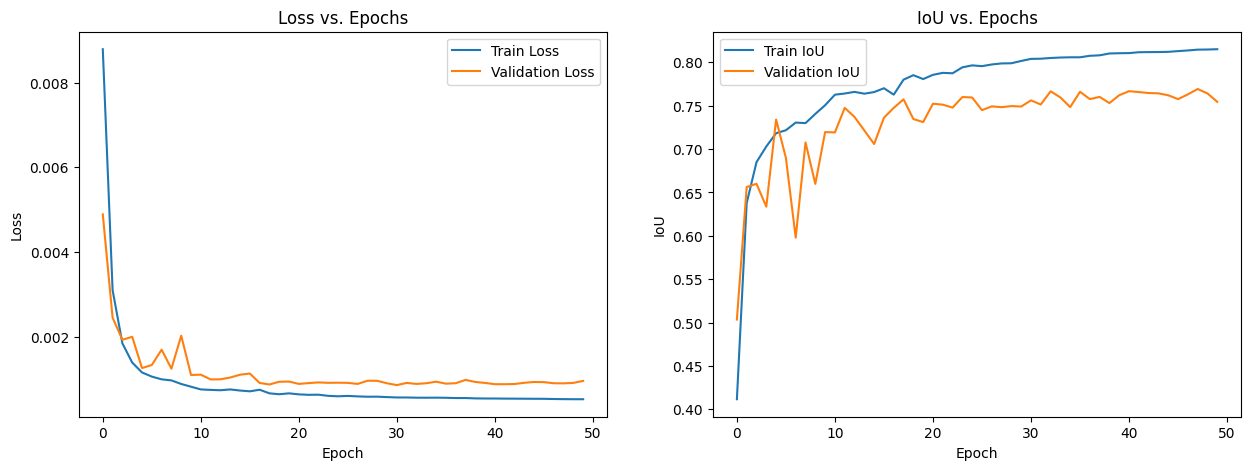

In [22]:
#5. Graphing Training & Validation Metrics
def calculate_iou_binary(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def find_best_threshold(model, val_loader, device):
    model.eval()
    thresholds = np.linspace(0.05, 0.95, 19)  
    iou_scores = []

    with torch.no_grad():
        for th in thresholds:
            total_iou = 0.0
            count = 0

            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                outputs = model(imgs)
                pred = torch.sigmoid(outputs[-1])

                pred_bin = (pred > th).float()
                total_iou += calculate_iou_binary(pred_bin, masks).item()
                count += 1

            avg_iou = total_iou / count
            iou_scores.append(avg_iou)
            print(f"Threshold {th:.2f} → IoU: {avg_iou:.4f}")

    best_idx = np.argmax(iou_scores)
    best_threshold = thresholds[best_idx]
    print(f" Mejor threshold encontrado: {best_threshold:.2f}")
    print(f" IoU con ese threshold: {iou_scores[best_idx]:.4f}")


    return best_threshold, iou_scores

def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot IoU
    ax2.plot(history['train_iou'], label='Train IoU')
    ax2.plot(history['val_iou'], label='Validation IoU')
    ax2.set_title("IoU vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("IoU")
    ax2.legend()

    plt.show()

# Call the function
plot_metrics(history)

Running evaluation on test set...


Testing: 100%|██████████| 155/155 [00:12<00:00, 12.13it/s]



--- Average Test IoU: 0.7933 ---


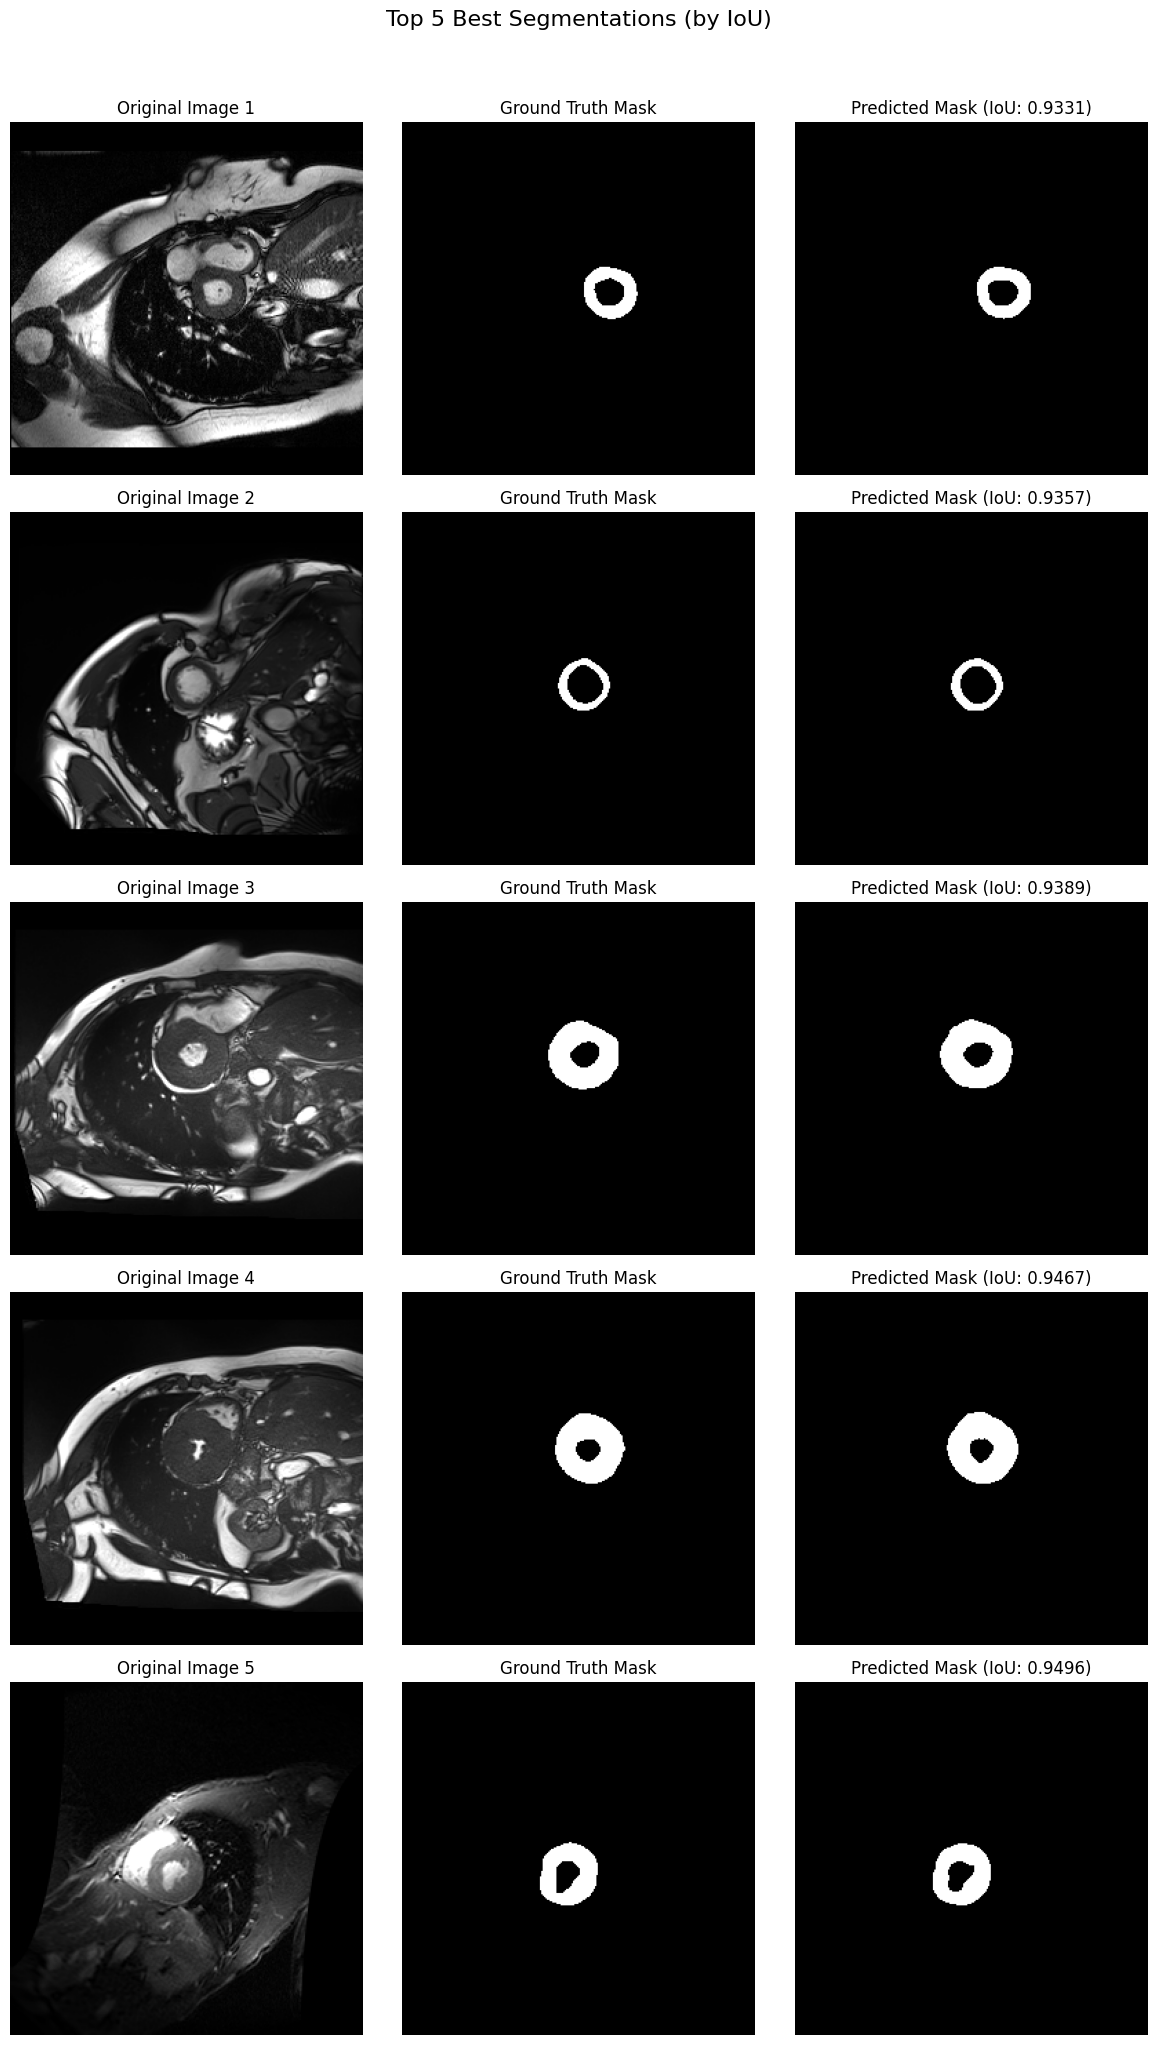

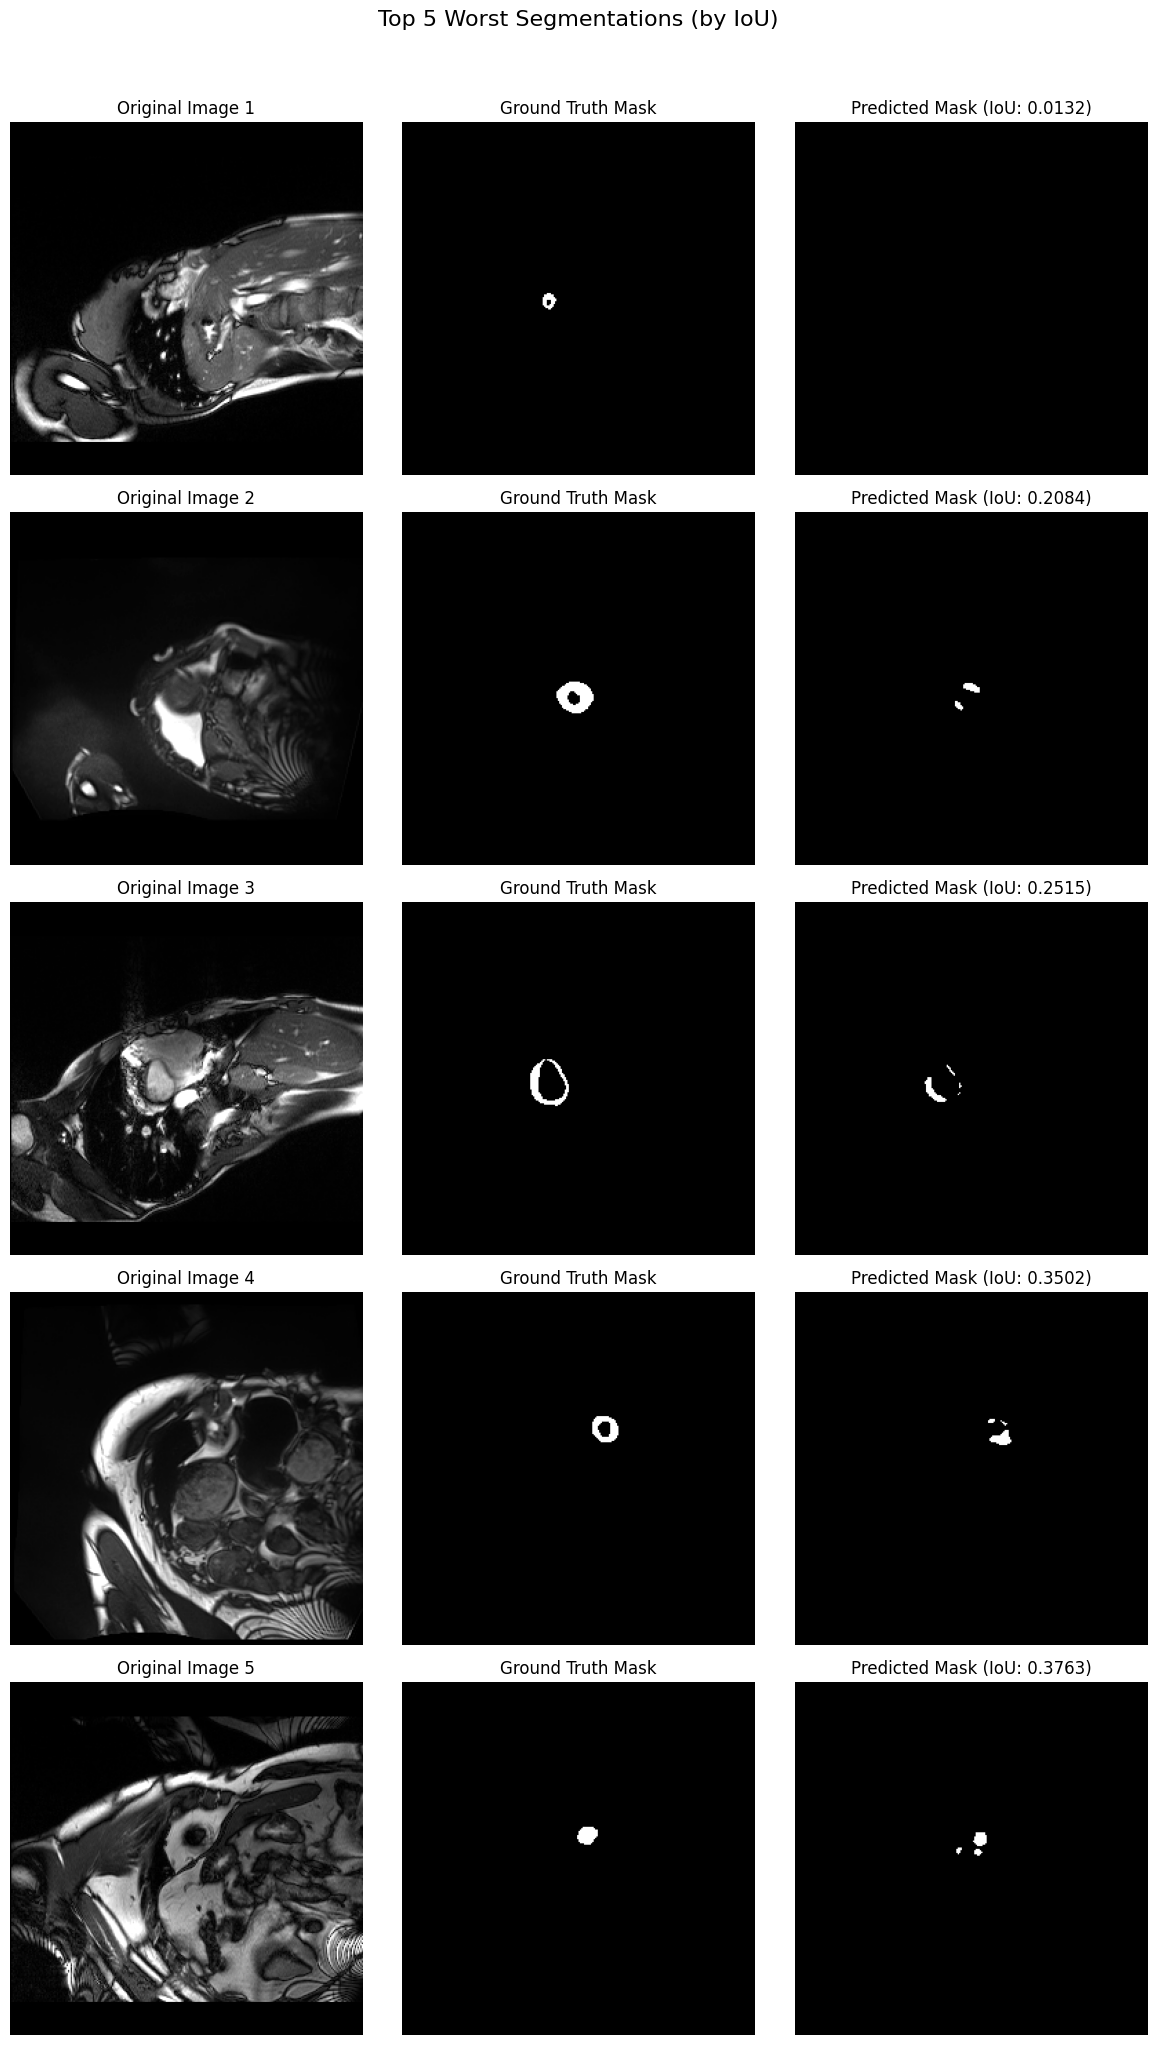

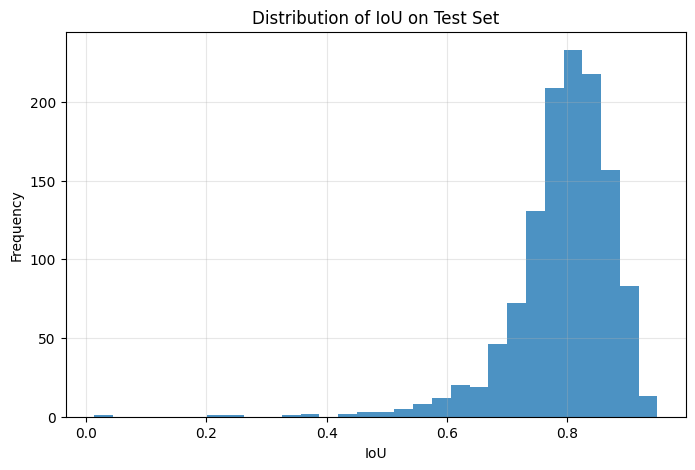

In [25]:
# 6. Test Set Evaluation

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Helper function to plot samples ---
def plot_samples(images, gt_masks, pred_masks, iou_scores, title):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images) * 4))
    fig.suptitle(title, fontsize=16, y=1.02)

    for i in range(len(images)):
        # Convertir a NumPy
        img = images[i].cpu().numpy().squeeze()
        gt = gt_masks[i].cpu().numpy().squeeze()
        pred = pred_masks[i].cpu().numpy().squeeze()

        # Aplicar Sigmoid y umbral a la predicción
        pred = 1 / (1 + np.exp(-pred))  # Sigmoid
        pred = (pred > 0.5).astype(float)

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask (IoU: {iou_scores[i]:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# --- Create Test Dataset and DataLoader ---
test_dataset = MyocardiumDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- Load the best model ---
model = UnetFunnel(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load('best_unet_funnel_focal.pth', map_location=device))
model.eval()


# --- Store all test results ---
all_test_ious = []
all_images = []
all_gt_masks = []
all_pred_masks = []

print("Running evaluation on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        # El modelo devuelve una sola salida
        outputs = model(images)
        output_final = outputs

        # Calcular IoU por muestra
        for i in range(images.shape[0]):
            img = images[i]
            gt = masks[i]
            pred = output_final[i]

            iou = calculate_iou(pred, gt).item()

            all_test_ious.append(iou)
            all_images.append(img)
            all_gt_masks.append(gt)
            all_pred_masks.append(pred)


# --- Calculate Average IoU ---
avg_test_iou = np.mean(all_test_ious)
print(f"\n--- Average Test IoU: {avg_test_iou:.4f} ---")


# --- Find Best and Worst Samples ---
sorted_indices = np.argsort(all_test_ious)

best_indices = sorted_indices[-5:]
best_images = [all_images[i] for i in best_indices]
best_gts = [all_gt_masks[i] for i in best_indices]
best_preds = [all_pred_masks[i] for i in best_indices]
best_ious = [all_test_ious[i] for i in best_indices]

worst_indices = sorted_indices[:5]
worst_images = [all_images[i] for i in worst_indices]
worst_gts = [all_gt_masks[i] for i in worst_indices]
worst_preds = [all_pred_masks[i] for i in worst_indices]
worst_ious = [all_test_ious[i] for i in worst_indices]


# --- Plot ---
plot_samples(best_images, best_gts, best_preds, best_ious, "Top 5 Best Segmentations (by IoU)")
plot_samples(worst_images, worst_gts, worst_preds, worst_ious, "Top 5 Worst Segmentations (by IoU)")


# Histograma de IoUs
plt.figure(figsize=(8,5))
plt.hist(all_test_ious, bins=30, alpha=0.8)
plt.title("Distribution of IoU on Test Set")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

**Alpha=0.65**

In [ ]:
# 4. Set up and run the training loop (MONAI FocalLoss)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim




# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UnetFunnel(in_channels=1, out_channels=1).to(device)

criterion = BinaryFocalLoss(alpha=0.65, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)


# --- Métrica IoU ---
def calculate_iou(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


# --- Historial ---
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

NUM_EPOCHS = 50
best_val_iou = -1.0
print("Starting training...")


# ===========================
#       TRAINING LOOP
# ===========================
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss, train_iou = 0.0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in pbar:

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # SALIDA ÚNICA
        outputs = model(images)

        # Focal Loss
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += calculate_iou(outputs, masks).item()

        pbar.set_postfix({'Train Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_iou'].append(avg_train_iou)


    # ===========================
    #       VALIDATION LOOP
    # ===========================
    model.eval()
    val_loss, val_iou = 0.0, 0.0

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")

        for images, masks in pbar_val:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # salida única

            vloss = criterion(outputs, masks)
            val_loss += vloss.item()

            val_iou += calculate_iou(outputs, masks).item()
            pbar_val.set_postfix({'Val Loss': vloss.item()})

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_iou'].append(avg_val_iou)


    # LR Scheduler
    scheduler.step(avg_val_iou)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss {avg_train_loss:.4f} | Train IoU {avg_train_iou:.4f} | "
          f"Val Loss {avg_val_loss:.4f} | Val IoU {avg_val_iou:.4f} | LR {current_lr:.1e}")


    # Guardar mejor modelo
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), 'best_unet_funnel_focal.pth')
        print(f"✅ New best model saved with IoU: {best_val_iou:.4f}")

print("Training finished.")


Using device: cuda
Starting training...


Epoch 1/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.00545]


Epoch 01 | Train Loss 0.0124 | Train IoU 0.3515 | Val Loss 0.0064 | Val IoU 0.4698 | LR 1.0e-04
✅ New best model saved with IoU: 0.4698


Epoch 2/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.00298]


Epoch 02 | Train Loss 0.0040 | Train IoU 0.6418 | Val Loss 0.0034 | Val IoU 0.5914 | LR 1.0e-04
✅ New best model saved with IoU: 0.5914


Epoch 3/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.00217]


Epoch 03 | Train Loss 0.0023 | Train IoU 0.6978 | Val Loss 0.0021 | Val IoU 0.6879 | LR 1.0e-04
✅ New best model saved with IoU: 0.6879


Epoch 4/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.00156] 


Epoch 04 | Train Loss 0.0016 | Train IoU 0.7299 | Val Loss 0.0018 | Val IoU 0.6666 | LR 1.0e-04


Epoch 5/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.00161]


Epoch 05 | Train Loss 0.0014 | Train IoU 0.7289 | Val Loss 0.0024 | Val IoU 0.5733 | LR 1.0e-04


Epoch 6/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, Val Loss=0.00142] 


Epoch 06 | Train Loss 0.0012 | Train IoU 0.7461 | Val Loss 0.0018 | Val IoU 0.6746 | LR 1.0e-04


Epoch 7/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.00125] 


Epoch 07 | Train Loss 0.0011 | Train IoU 0.7428 | Val Loss 0.0017 | Val IoU 0.6528 | LR 1.0e-04


Epoch 8/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000989]


Epoch 08 | Train Loss 0.0011 | Train IoU 0.7498 | Val Loss 0.0013 | Val IoU 0.6943 | LR 1.0e-04
✅ New best model saved with IoU: 0.6943


Epoch 9/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.10it/s, Val Loss=0.000839]


Epoch 09 | Train Loss 0.0010 | Train IoU 0.7525 | Val Loss 0.0012 | Val IoU 0.7365 | LR 1.0e-04
✅ New best model saved with IoU: 0.7365


Epoch 10/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.12it/s, Val Loss=0.00103] 


Epoch 10 | Train Loss 0.0009 | Train IoU 0.7661 | Val Loss 0.0015 | Val IoU 0.6894 | LR 1.0e-04


Epoch 11/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s, Val Loss=0.000832]


Epoch 11 | Train Loss 0.0009 | Train IoU 0.7638 | Val Loss 0.0017 | Val IoU 0.6505 | LR 1.0e-04


Epoch 12/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.000849]


Epoch 12 | Train Loss 0.0010 | Train IoU 0.7575 | Val Loss 0.0018 | Val IoU 0.6491 | LR 1.0e-04


Epoch 13/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s, Val Loss=0.000985]


Epoch 13 | Train Loss 0.0009 | Train IoU 0.7648 | Val Loss 0.0011 | Val IoU 0.7553 | LR 1.0e-04
✅ New best model saved with IoU: 0.7553


Epoch 14/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.15it/s, Val Loss=0.00554] 


Epoch 14 | Train Loss 0.0009 | Train IoU 0.7686 | Val Loss 0.0064 | Val IoU 0.3660 | LR 1.0e-04


Epoch 15/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.00076] 


Epoch 15 | Train Loss 0.0009 | Train IoU 0.7730 | Val Loss 0.0012 | Val IoU 0.7351 | LR 1.0e-04


Epoch 16/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.000967]


Epoch 16 | Train Loss 0.0009 | Train IoU 0.7677 | Val Loss 0.0013 | Val IoU 0.7143 | LR 1.0e-04


Epoch 17/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.00123] 


Epoch 17 | Train Loss 0.0009 | Train IoU 0.7720 | Val Loss 0.0090 | Val IoU 0.3188 | LR 1.0e-04


Epoch 18/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s, Val Loss=0.000867]


Epoch 18 | Train Loss 0.0009 | Train IoU 0.7713 | Val Loss 0.0016 | Val IoU 0.6771 | LR 5.0e-05


Epoch 19/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.000772]


Epoch 19 | Train Loss 0.0008 | Train IoU 0.7927 | Val Loss 0.0012 | Val IoU 0.7254 | LR 5.0e-05


Epoch 20/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000781]


Epoch 20 | Train Loss 0.0007 | Train IoU 0.7962 | Val Loss 0.0011 | Val IoU 0.7441 | LR 5.0e-05


Epoch 21/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000871]


Epoch 21 | Train Loss 0.0008 | Train IoU 0.7936 | Val Loss 0.0013 | Val IoU 0.7254 | LR 5.0e-05


Epoch 22/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000784]


Epoch 22 | Train Loss 0.0008 | Train IoU 0.7919 | Val Loss 0.0014 | Val IoU 0.6950 | LR 5.0e-05


Epoch 23/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000813]


Epoch 23 | Train Loss 0.0008 | Train IoU 0.7943 | Val Loss 0.0010 | Val IoU 0.7673 | LR 5.0e-05
✅ New best model saved with IoU: 0.7673


Epoch 24/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s, Val Loss=0.000695]


Epoch 24 | Train Loss 0.0007 | Train IoU 0.8002 | Val Loss 0.0010 | Val IoU 0.7671 | LR 5.0e-05


Epoch 25/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000797]


Epoch 25 | Train Loss 0.0007 | Train IoU 0.7981 | Val Loss 0.0011 | Val IoU 0.7363 | LR 5.0e-05


Epoch 26/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000761]


Epoch 26 | Train Loss 0.0007 | Train IoU 0.7999 | Val Loss 0.0011 | Val IoU 0.7308 | LR 5.0e-05


Epoch 27/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000726]


Epoch 27 | Train Loss 0.0007 | Train IoU 0.7958 | Val Loss 0.0012 | Val IoU 0.7334 | LR 5.0e-05


Epoch 28/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000666]


Epoch 28 | Train Loss 0.0007 | Train IoU 0.8017 | Val Loss 0.0010 | Val IoU 0.7606 | LR 2.5e-05


Epoch 29/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.0008]  


Epoch 29 | Train Loss 0.0007 | Train IoU 0.8098 | Val Loss 0.0010 | Val IoU 0.7553 | LR 2.5e-05


Epoch 30/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.25it/s, Val Loss=0.000683]


Epoch 30 | Train Loss 0.0007 | Train IoU 0.8108 | Val Loss 0.0010 | Val IoU 0.7682 | LR 2.5e-05
✅ New best model saved with IoU: 0.7682


Epoch 31/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000691]


Epoch 31 | Train Loss 0.0007 | Train IoU 0.8118 | Val Loss 0.0010 | Val IoU 0.7689 | LR 2.5e-05
✅ New best model saved with IoU: 0.7689


Epoch 32/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000765]


Epoch 32 | Train Loss 0.0007 | Train IoU 0.8127 | Val Loss 0.0010 | Val IoU 0.7792 | LR 2.5e-05
✅ New best model saved with IoU: 0.7792


Epoch 33/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000784]


Epoch 33 | Train Loss 0.0007 | Train IoU 0.8139 | Val Loss 0.0009 | Val IoU 0.7783 | LR 2.5e-05


Epoch 34/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.29it/s, Val Loss=0.000782]


Epoch 34 | Train Loss 0.0007 | Train IoU 0.8121 | Val Loss 0.0010 | Val IoU 0.7642 | LR 2.5e-05


Epoch 35/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000914]


Epoch 35 | Train Loss 0.0007 | Train IoU 0.8116 | Val Loss 0.0011 | Val IoU 0.7470 | LR 2.5e-05


Epoch 36/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.00072] 


Epoch 36 | Train Loss 0.0007 | Train IoU 0.8138 | Val Loss 0.0010 | Val IoU 0.7662 | LR 2.5e-05


Epoch 37/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000741]


Epoch 37 | Train Loss 0.0006 | Train IoU 0.8168 | Val Loss 0.0010 | Val IoU 0.7733 | LR 1.3e-05


Epoch 38/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000728]


Epoch 38 | Train Loss 0.0006 | Train IoU 0.8201 | Val Loss 0.0010 | Val IoU 0.7554 | LR 1.3e-05


Epoch 39/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000693]


Epoch 39 | Train Loss 0.0006 | Train IoU 0.8210 | Val Loss 0.0010 | Val IoU 0.7679 | LR 1.3e-05


Epoch 40/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s, Val Loss=0.0007]  


Epoch 40 | Train Loss 0.0006 | Train IoU 0.8215 | Val Loss 0.0010 | Val IoU 0.7587 | LR 1.3e-05


Epoch 41/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.15it/s, Val Loss=0.000702]


Epoch 41 | Train Loss 0.0006 | Train IoU 0.8215 | Val Loss 0.0010 | Val IoU 0.7729 | LR 1.3e-05


Epoch 42/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000727]


Epoch 42 | Train Loss 0.0006 | Train IoU 0.8232 | Val Loss 0.0010 | Val IoU 0.7764 | LR 6.3e-06


Epoch 43/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.00076] 


Epoch 43 | Train Loss 0.0006 | Train IoU 0.8256 | Val Loss 0.0010 | Val IoU 0.7724 | LR 6.3e-06


Epoch 44/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000734]


Epoch 44 | Train Loss 0.0006 | Train IoU 0.8259 | Val Loss 0.0009 | Val IoU 0.7781 | LR 6.3e-06


Epoch 45/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000732]


Epoch 45 | Train Loss 0.0006 | Train IoU 0.8265 | Val Loss 0.0010 | Val IoU 0.7762 | LR 6.3e-06


Epoch 46/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s, Val Loss=0.000814]


Epoch 46 | Train Loss 0.0006 | Train IoU 0.8262 | Val Loss 0.0010 | Val IoU 0.7788 | LR 6.3e-06


Epoch 47/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000729]


Epoch 47 | Train Loss 0.0006 | Train IoU 0.8268 | Val Loss 0.0009 | Val IoU 0.7730 | LR 3.1e-06


Epoch 48/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.0007]  


Epoch 48 | Train Loss 0.0006 | Train IoU 0.8277 | Val Loss 0.0010 | Val IoU 0.7791 | LR 3.1e-06


Epoch 49/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000759]


Epoch 49 | Train Loss 0.0006 | Train IoU 0.8291 | Val Loss 0.0010 | Val IoU 0.7778 | LR 3.1e-06


Epoch 50/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s, Val Loss=0.00072] 

Epoch 50 | Train Loss 0.0006 | Train IoU 0.8291 | Val Loss 0.0010 | Val IoU 0.7736 | LR 3.1e-06
Training finished.


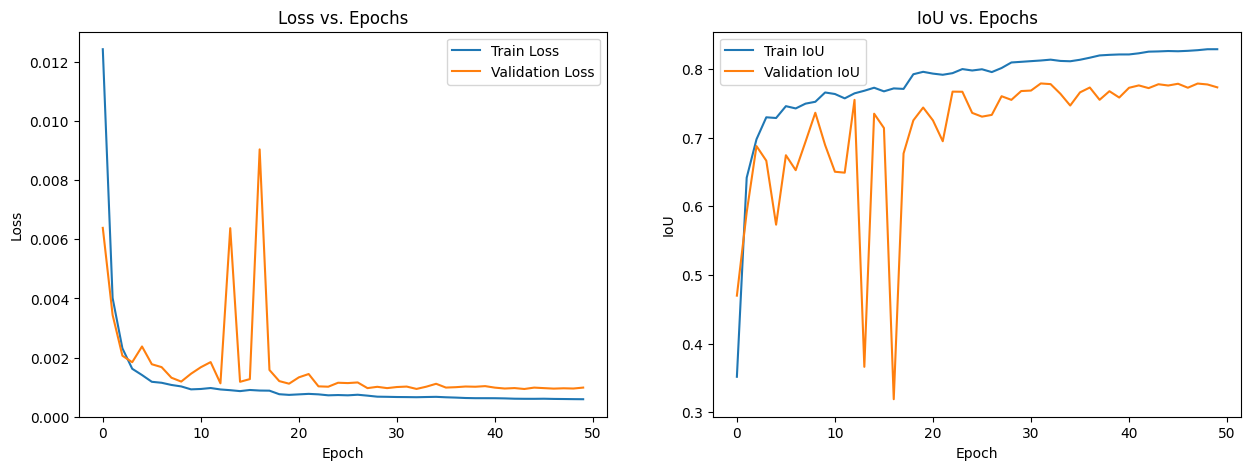

In [ ]:
#5. Graphing Training & Validation Metrics
def calculate_iou_binary(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def find_best_threshold(model, val_loader, device):
    model.eval()
    thresholds = np.linspace(0.05, 0.95, 19)  
    iou_scores = []

    with torch.no_grad():
        for th in thresholds:
            total_iou = 0.0
            count = 0

            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                outputs = model(imgs)
                pred = torch.sigmoid(outputs[-1])

                pred_bin = (pred > th).float()
                total_iou += calculate_iou_binary(pred_bin, masks).item()
                count += 1

            avg_iou = total_iou / count
            iou_scores.append(avg_iou)
            print(f"Threshold {th:.2f} → IoU: {avg_iou:.4f}")

    best_idx = np.argmax(iou_scores)
    best_threshold = thresholds[best_idx]
    print(f" Mejor threshold encontrado: {best_threshold:.2f}")
    print(f" IoU con ese threshold: {iou_scores[best_idx]:.4f}")


    return best_threshold, iou_scores

def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot IoU
    ax2.plot(history['train_iou'], label='Train IoU')
    ax2.plot(history['val_iou'], label='Validation IoU')
    ax2.set_title("IoU vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("IoU")
    ax2.legend()

    plt.show()

# Call the function
plot_metrics(history)

Running evaluation on test set...


Testing: 100%|██████████| 155/155 [00:12<00:00, 12.18it/s]



--- Average Test IoU: 0.7839 ---


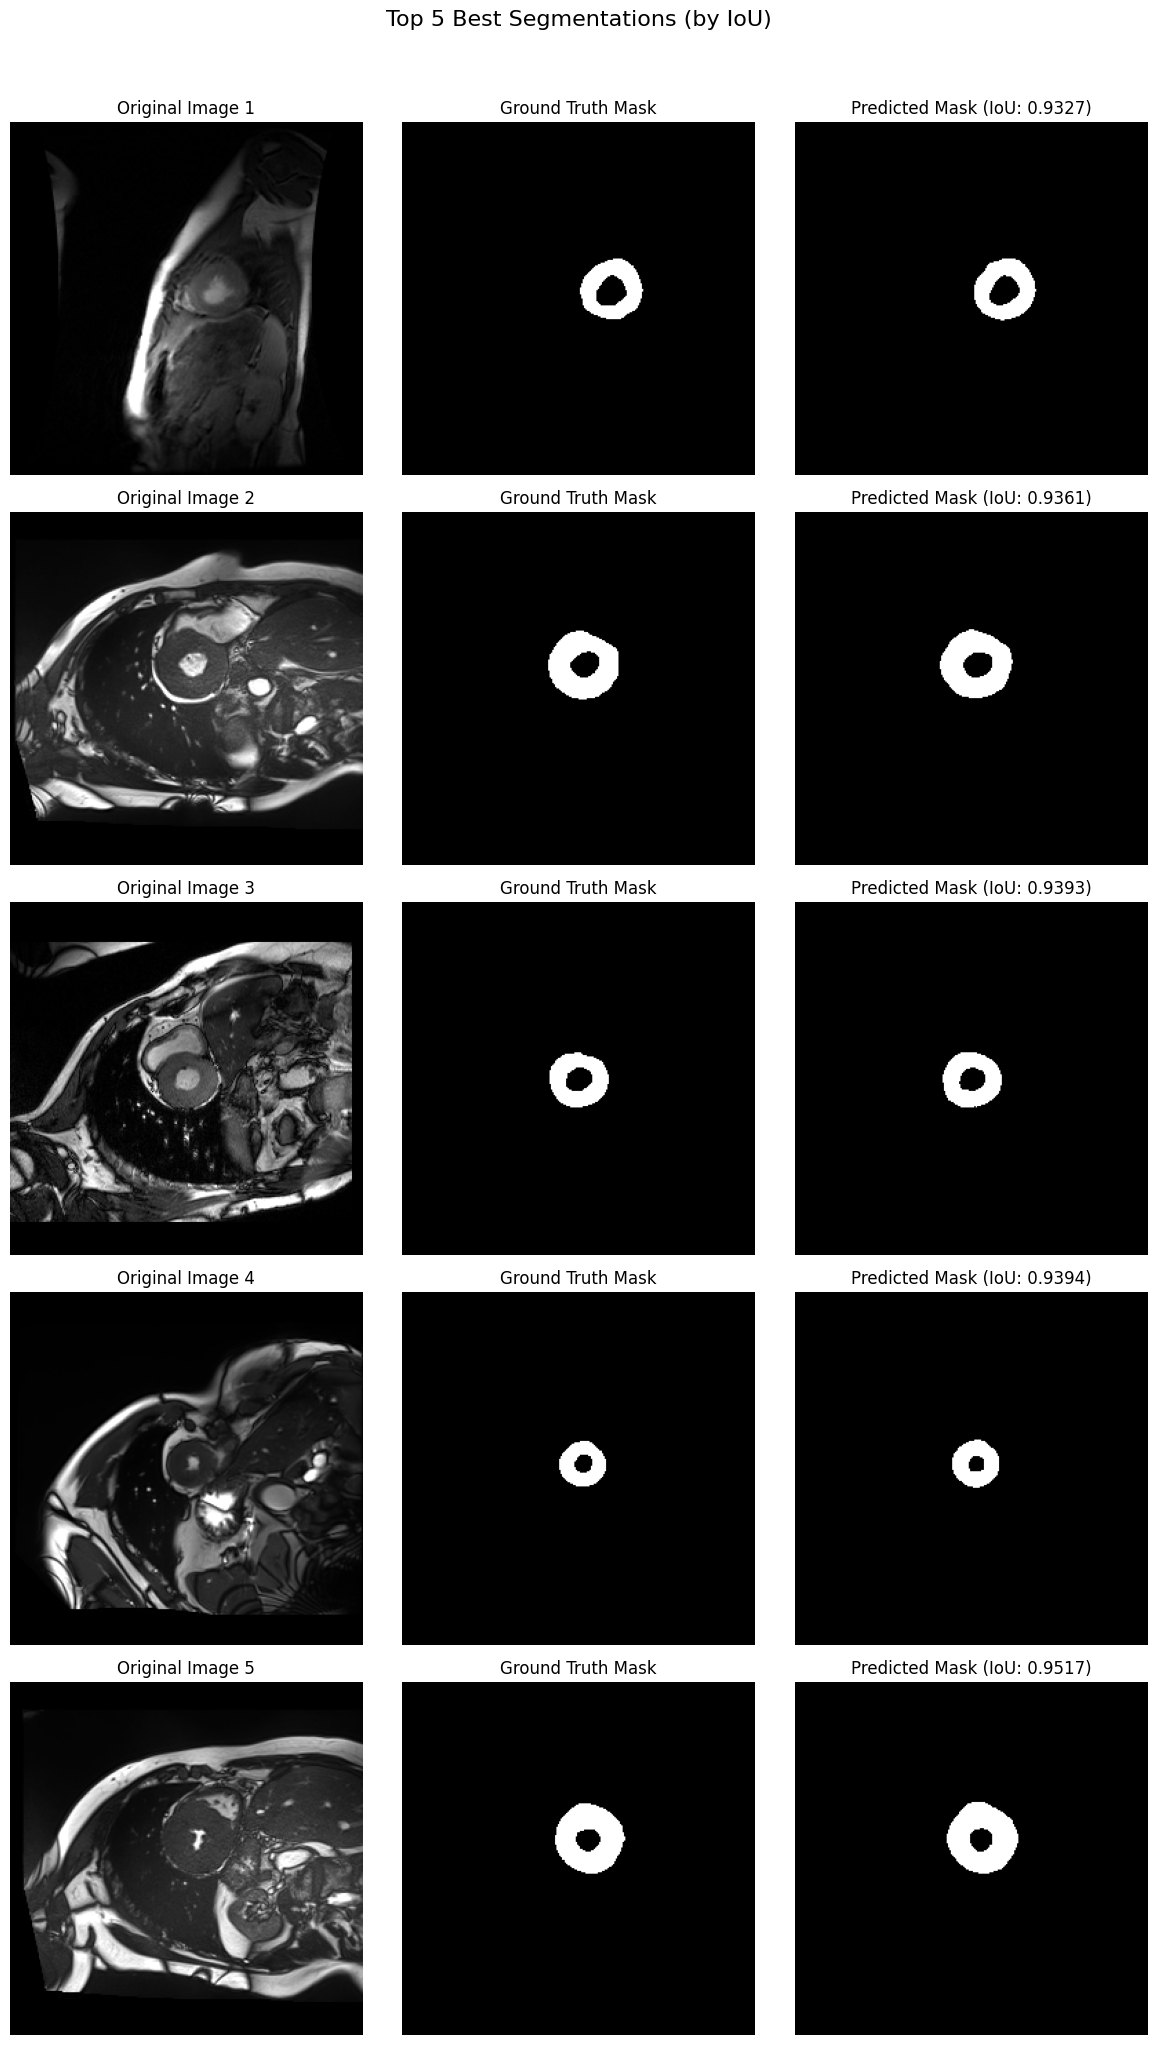

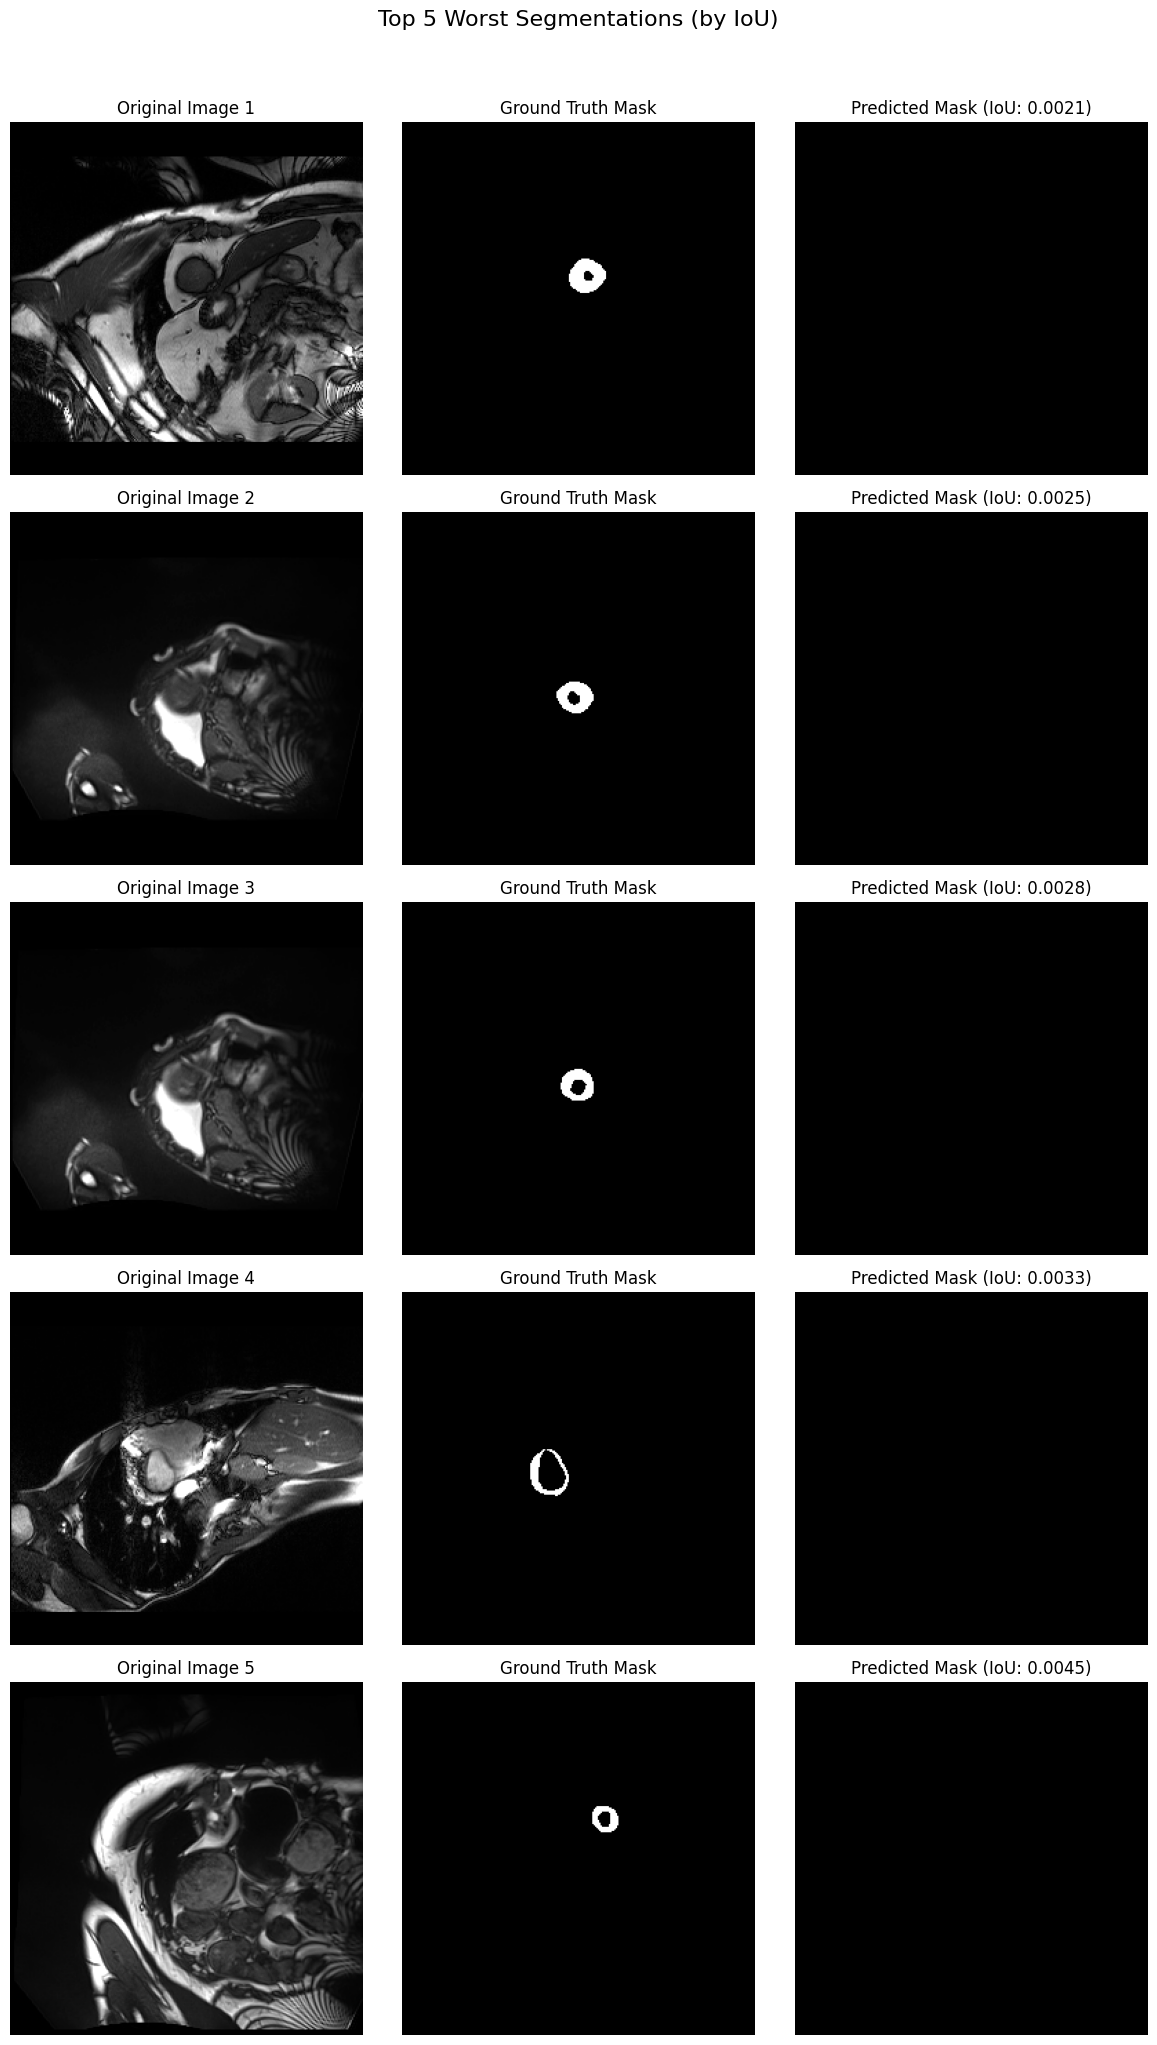

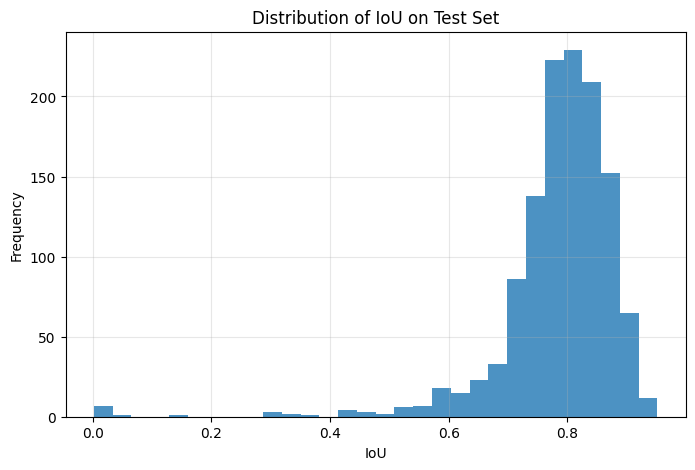

In [ ]:
# 6. Test Set Evaluation

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Helper function to plot samples ---
def plot_samples(images, gt_masks, pred_masks, iou_scores, title):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images) * 4))
    fig.suptitle(title, fontsize=16, y=1.02)

    for i in range(len(images)):
        # Convertir a NumPy
        img = images[i].cpu().numpy().squeeze()
        gt = gt_masks[i].cpu().numpy().squeeze()
        pred = pred_masks[i].cpu().numpy().squeeze()

        # Aplicar Sigmoid y umbral a la predicción
        pred = 1 / (1 + np.exp(-pred))  # Sigmoid
        pred = (pred > 0.45).astype(float)

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask (IoU: {iou_scores[i]:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# --- Create Test Dataset and DataLoader ---
test_dataset = MyocardiumDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- Load the best model ---
model = UnetFunnel(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load('best_unet_funnel_focal.pth', map_location=device))
model.eval()


# --- Store all test results ---
all_test_ious = []
all_images = []
all_gt_masks = []
all_pred_masks = []

print("Running evaluation on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        # El modelo devuelve una sola salida
        outputs = model(images)
        output_final = outputs

        # Calcular IoU por muestra
        for i in range(images.shape[0]):
            img = images[i]
            gt = masks[i]
            pred = output_final[i]

            iou = calculate_iou(pred, gt).item()

            all_test_ious.append(iou)
            all_images.append(img)
            all_gt_masks.append(gt)
            all_pred_masks.append(pred)


# --- Calculate Average IoU ---
avg_test_iou = np.mean(all_test_ious)
print(f"\n--- Average Test IoU: {avg_test_iou:.4f} ---")


# --- Find Best and Worst Samples ---
sorted_indices = np.argsort(all_test_ious)

best_indices = sorted_indices[-5:]
best_images = [all_images[i] for i in best_indices]
best_gts = [all_gt_masks[i] for i in best_indices]
best_preds = [all_pred_masks[i] for i in best_indices]
best_ious = [all_test_ious[i] for i in best_indices]

worst_indices = sorted_indices[:5]
worst_images = [all_images[i] for i in worst_indices]
worst_gts = [all_gt_masks[i] for i in worst_indices]
worst_preds = [all_pred_masks[i] for i in worst_indices]
worst_ious = [all_test_ious[i] for i in worst_indices]


# --- Plot ---
plot_samples(best_images, best_gts, best_preds, best_ious, "Top 5 Best Segmentations (by IoU)")
plot_samples(worst_images, worst_gts, worst_preds, worst_ious, "Top 5 Worst Segmentations (by IoU)")


# Histograma de IoUs
plt.figure(figsize=(8,5))
plt.hist(all_test_ious, bins=30, alpha=0.8)
plt.title("Distribution of IoU on Test Set")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

**Alpha = 0.95**

In [ ]:
# 4. Set up and run the training loop (MONAI FocalLoss)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UnetFunnel(in_channels=1, out_channels=1).to(device)

criterion = BinaryFocalLoss(alpha=0.95, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)

# --- Métrica IoU ---
def calculate_iou(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# --- Historial ---
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

NUM_EPOCHS = 50
best_val_iou = -1.0
print("Starting training...")

# ===========================
#       EARLY STOPPING
# ===========================
patience = 10                # número de épocas permitidas sin mejora
early_stop_counter = 0       # contador de épocas sin mejora

for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss, train_iou = 0.0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in pbar:

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += calculate_iou(outputs, masks).item()

        pbar.set_postfix({'Train Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_iou'].append(avg_train_iou)

    # ===========================
    #       VALIDATION LOOP
    # ===========================
    model.eval()
    val_loss, val_iou = 0.0, 0.0

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")

        for images, masks in pbar_val:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            vloss = criterion(outputs, masks)
            val_loss += vloss.item()
            val_iou += calculate_iou(outputs, masks).item()

            pbar_val.set_postfix({'Val Loss': vloss.item()})

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_iou'].append(avg_val_iou)

    # LR Scheduler
    scheduler.step(avg_val_iou)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss {avg_train_loss:.4f} | Train IoU {avg_train_iou:.4f} | "
          f"Val Loss {avg_val_loss:.4f} | Val IoU {avg_val_iou:.4f} | LR {current_lr:.1e}")

    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), 'best_unet_funnel_focal.pth')
        print(f"✅ New best model saved with IoU: {best_val_iou:.4f}")

        early_stop_counter = 0   #
    else:
        early_stop_counter += 1  # aumenta contador

    # ===========================
    #        EARLY STOPPING
    # ===========================
    if early_stop_counter >= patience:
        print(f"\n⛔ EARLY STOPPING triggered after {patience} epochs without improvement.")
        break

print("Training finished.")


Using device: cuda
Starting training...


Epoch 1/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.18it/s, Val Loss=0.00183]


Epoch 01 | Train Loss 0.0038 | Train IoU 0.3124 | Val Loss 0.0023 | Val IoU 0.3967 | LR 1.0e-04
✅ New best model saved with IoU: 0.3967


Epoch 2/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.00118] 


Epoch 02 | Train Loss 0.0015 | Train IoU 0.4876 | Val Loss 0.0014 | Val IoU 0.4970 | LR 1.0e-04
✅ New best model saved with IoU: 0.4970


Epoch 3/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s, Val Loss=0.000749]


Epoch 03 | Train Loss 0.0010 | Train IoU 0.5157 | Val Loss 0.0009 | Val IoU 0.5185 | LR 1.0e-04
✅ New best model saved with IoU: 0.5185


Epoch 4/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s, Val Loss=0.00061] 


Epoch 04 | Train Loss 0.0008 | Train IoU 0.5386 | Val Loss 0.0010 | Val IoU 0.5467 | LR 1.0e-04
✅ New best model saved with IoU: 0.5467


Epoch 5/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.25it/s, Val Loss=0.000627]


Epoch 05 | Train Loss 0.0006 | Train IoU 0.5531 | Val Loss 0.0009 | Val IoU 0.5648 | LR 1.0e-04
✅ New best model saved with IoU: 0.5648


Epoch 6/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000524]


Epoch 06 | Train Loss 0.0006 | Train IoU 0.5602 | Val Loss 0.0006 | Val IoU 0.5585 | LR 1.0e-04


Epoch 7/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, Val Loss=0.000443]


Epoch 07 | Train Loss 0.0005 | Train IoU 0.5756 | Val Loss 0.0014 | Val IoU 0.5864 | LR 1.0e-04
✅ New best model saved with IoU: 0.5864


Epoch 8/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, Val Loss=0.000408]


Epoch 08 | Train Loss 0.0005 | Train IoU 0.5686 | Val Loss 0.0008 | Val IoU 0.6202 | LR 1.0e-04
✅ New best model saved with IoU: 0.6202


Epoch 9/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000686]


Epoch 09 | Train Loss 0.0005 | Train IoU 0.5848 | Val Loss 0.0007 | Val IoU 0.4946 | LR 1.0e-04


Epoch 10/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000439]


Epoch 10 | Train Loss 0.0005 | Train IoU 0.5810 | Val Loss 0.0006 | Val IoU 0.6527 | LR 1.0e-04
✅ New best model saved with IoU: 0.6527


Epoch 11/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000385]


Epoch 11 | Train Loss 0.0005 | Train IoU 0.5812 | Val Loss 0.0007 | Val IoU 0.5505 | LR 1.0e-04


Epoch 12/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000628]


Epoch 12 | Train Loss 0.0004 | Train IoU 0.6049 | Val Loss 0.0011 | Val IoU 0.5601 | LR 1.0e-04


Epoch 13/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.25it/s, Val Loss=0.000365]


Epoch 13 | Train Loss 0.0005 | Train IoU 0.5938 | Val Loss 0.0007 | Val IoU 0.6041 | LR 1.0e-04


Epoch 14/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000438]


Epoch 14 | Train Loss 0.0004 | Train IoU 0.5938 | Val Loss 0.0008 | Val IoU 0.5498 | LR 1.0e-04


Epoch 15/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, Val Loss=0.000343]


Epoch 15 | Train Loss 0.0004 | Train IoU 0.6148 | Val Loss 0.0006 | Val IoU 0.5925 | LR 5.0e-05


Epoch 16/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000336]


Epoch 16 | Train Loss 0.0003 | Train IoU 0.6431 | Val Loss 0.0005 | Val IoU 0.6386 | LR 5.0e-05


Epoch 17/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s, Val Loss=0.000308]


Epoch 17 | Train Loss 0.0003 | Train IoU 0.6420 | Val Loss 0.0005 | Val IoU 0.6471 | LR 5.0e-05


Epoch 18/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000341]


Epoch 18 | Train Loss 0.0004 | Train IoU 0.6390 | Val Loss 0.0006 | Val IoU 0.6410 | LR 5.0e-05


Epoch 19/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.27it/s, Val Loss=0.000345]


Epoch 19 | Train Loss 0.0003 | Train IoU 0.6514 | Val Loss 0.0006 | Val IoU 0.6207 | LR 5.0e-05


Epoch 20/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s, Val Loss=0.000296]


Epoch 20 | Train Loss 0.0003 | Train IoU 0.6402 | Val Loss 0.0005 | Val IoU 0.6557 | LR 5.0e-05
✅ New best model saved with IoU: 0.6557


Epoch 21/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, Val Loss=0.000317]


Epoch 21 | Train Loss 0.0003 | Train IoU 0.6478 | Val Loss 0.0005 | Val IoU 0.6340 | LR 5.0e-05


Epoch 22/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000355]


Epoch 22 | Train Loss 0.0004 | Train IoU 0.6348 | Val Loss 0.0005 | Val IoU 0.5907 | LR 5.0e-05


Epoch 23/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000319]


Epoch 23 | Train Loss 0.0003 | Train IoU 0.6520 | Val Loss 0.0005 | Val IoU 0.6283 | LR 5.0e-05


Epoch 24/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000324]


Epoch 24 | Train Loss 0.0003 | Train IoU 0.6589 | Val Loss 0.0005 | Val IoU 0.6422 | LR 5.0e-05


Epoch 25/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000322]


Epoch 25 | Train Loss 0.0003 | Train IoU 0.6532 | Val Loss 0.0004 | Val IoU 0.6378 | LR 2.5e-05


Epoch 26/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000325]


Epoch 26 | Train Loss 0.0003 | Train IoU 0.6725 | Val Loss 0.0004 | Val IoU 0.6488 | LR 2.5e-05


Epoch 27/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s, Val Loss=0.000306]


Epoch 27 | Train Loss 0.0003 | Train IoU 0.6637 | Val Loss 0.0005 | Val IoU 0.6245 | LR 2.5e-05


Epoch 28/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, Val Loss=0.000354]


Epoch 28 | Train Loss 0.0003 | Train IoU 0.6711 | Val Loss 0.0005 | Val IoU 0.6258 | LR 2.5e-05


Epoch 29/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s, Val Loss=0.000294]


Epoch 29 | Train Loss 0.0003 | Train IoU 0.6757 | Val Loss 0.0004 | Val IoU 0.6478 | LR 2.5e-05


Epoch 30/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s, Val Loss=0.000293]


Epoch 30 | Train Loss 0.0003 | Train IoU 0.6783 | Val Loss 0.0005 | Val IoU 0.6613 | LR 2.5e-05
✅ New best model saved with IoU: 0.6613


Epoch 31/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, Val Loss=0.000301]


Epoch 31 | Train Loss 0.0003 | Train IoU 0.6730 | Val Loss 0.0005 | Val IoU 0.6599 | LR 2.5e-05


Epoch 32/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000308]


Epoch 32 | Train Loss 0.0003 | Train IoU 0.6748 | Val Loss 0.0004 | Val IoU 0.6545 | LR 2.5e-05


Epoch 33/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000335]


Epoch 33 | Train Loss 0.0003 | Train IoU 0.6813 | Val Loss 0.0005 | Val IoU 0.6799 | LR 2.5e-05
✅ New best model saved with IoU: 0.6799


Epoch 34/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000284]


Epoch 34 | Train Loss 0.0003 | Train IoU 0.6797 | Val Loss 0.0005 | Val IoU 0.6438 | LR 2.5e-05


Epoch 35/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000324]


Epoch 35 | Train Loss 0.0003 | Train IoU 0.6741 | Val Loss 0.0005 | Val IoU 0.6727 | LR 2.5e-05


Epoch 36/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, Val Loss=0.000289]


Epoch 36 | Train Loss 0.0003 | Train IoU 0.6836 | Val Loss 0.0005 | Val IoU 0.6702 | LR 2.5e-05


Epoch 37/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.17it/s, Val Loss=0.000296]


Epoch 37 | Train Loss 0.0003 | Train IoU 0.6790 | Val Loss 0.0004 | Val IoU 0.6510 | LR 2.5e-05


Epoch 38/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000269]


Epoch 38 | Train Loss 0.0003 | Train IoU 0.6777 | Val Loss 0.0005 | Val IoU 0.6448 | LR 1.3e-05


Epoch 39/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000304]


Epoch 39 | Train Loss 0.0003 | Train IoU 0.6899 | Val Loss 0.0005 | Val IoU 0.6740 | LR 1.3e-05


Epoch 40/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, Val Loss=0.000301]


Epoch 40 | Train Loss 0.0003 | Train IoU 0.6914 | Val Loss 0.0005 | Val IoU 0.6789 | LR 1.3e-05


Epoch 41/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000293]


Epoch 41 | Train Loss 0.0003 | Train IoU 0.6943 | Val Loss 0.0004 | Val IoU 0.6762 | LR 1.3e-05


Epoch 42/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000292]


Epoch 42 | Train Loss 0.0003 | Train IoU 0.6895 | Val Loss 0.0004 | Val IoU 0.6655 | LR 1.3e-05


Epoch 43/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000301]


Epoch 43 | Train Loss 0.0003 | Train IoU 0.6928 | Val Loss 0.0005 | Val IoU 0.6906 | LR 1.3e-05
✅ New best model saved with IoU: 0.6906


Epoch 44/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000289]


Epoch 44 | Train Loss 0.0003 | Train IoU 0.6939 | Val Loss 0.0005 | Val IoU 0.6924 | LR 1.3e-05
✅ New best model saved with IoU: 0.6924


Epoch 45/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, Val Loss=0.000279]


Epoch 45 | Train Loss 0.0003 | Train IoU 0.6952 | Val Loss 0.0004 | Val IoU 0.6710 | LR 1.3e-05


Epoch 46/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000268]


Epoch 46 | Train Loss 0.0003 | Train IoU 0.6993 | Val Loss 0.0004 | Val IoU 0.6693 | LR 1.3e-05


Epoch 47/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, Val Loss=0.000296]


Epoch 47 | Train Loss 0.0003 | Train IoU 0.6978 | Val Loss 0.0004 | Val IoU 0.6919 | LR 1.3e-05


Epoch 48/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000299]


Epoch 48 | Train Loss 0.0003 | Train IoU 0.6984 | Val Loss 0.0005 | Val IoU 0.6948 | LR 1.3e-05
✅ New best model saved with IoU: 0.6948


Epoch 49/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.21it/s, Val Loss=0.000308]


Epoch 49 | Train Loss 0.0003 | Train IoU 0.6986 | Val Loss 0.0004 | Val IoU 0.6648 | LR 1.3e-05


Epoch 50/50 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, Val Loss=0.000273]


Epoch 50 | Train Loss 0.0003 | Train IoU 0.6994 | Val Loss 0.0005 | Val IoU 0.6987 | LR 1.3e-05
✅ New best model saved with IoU: 0.6987
Training finished.


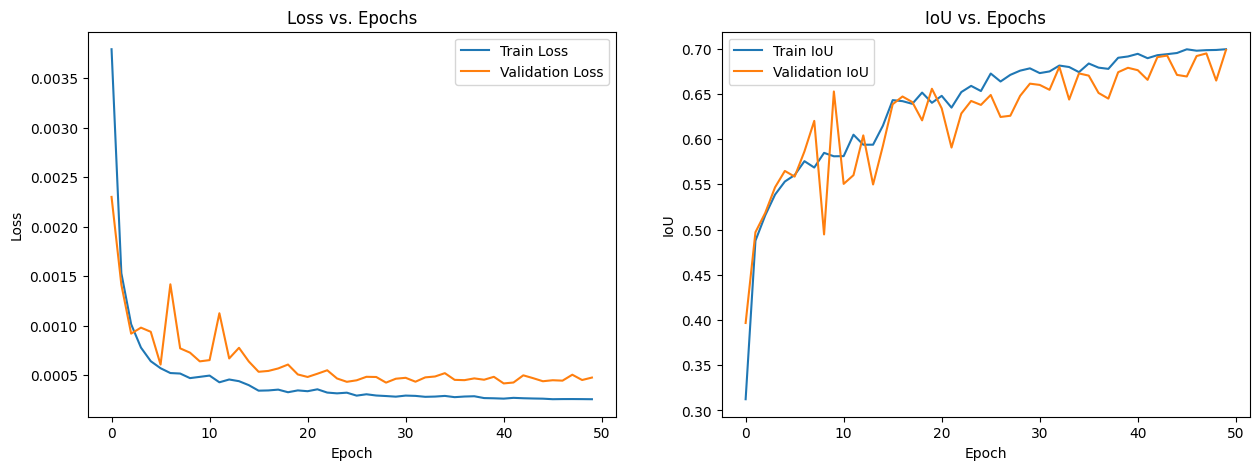

In [ ]:
#5. Graphing Training & Validation Metrics
def calculate_iou_binary(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def find_best_threshold(model, val_loader, device):
    model.eval()
    thresholds = np.linspace(0.05, 0.95, 19)  
    iou_scores = []

    with torch.no_grad():
        for th in thresholds:
            total_iou = 0.0
            count = 0

            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                outputs = model(imgs)
                pred = torch.sigmoid(outputs[-1])

                pred_bin = (pred > th).float()
                total_iou += calculate_iou_binary(pred_bin, masks).item()
                count += 1

            avg_iou = total_iou / count
            iou_scores.append(avg_iou)
            print(f"Threshold {th:.2f} → IoU: {avg_iou:.4f}")

    best_idx = np.argmax(iou_scores)
    best_threshold = thresholds[best_idx]
    print(f" Mejor threshold encontrado: {best_threshold:.2f}")
    print(f" IoU con ese threshold: {iou_scores[best_idx]:.4f}")


    return best_threshold, iou_scores

def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot IoU
    ax2.plot(history['train_iou'], label='Train IoU')
    ax2.plot(history['val_iou'], label='Validation IoU')
    ax2.set_title("IoU vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("IoU")
    ax2.legend()

    plt.show()

# Call the function
plot_metrics(history)

Running evaluation on test set...


Testing: 100%|██████████| 155/155 [00:12<00:00, 12.09it/s]



--- Average Test IoU: 0.7340 ---


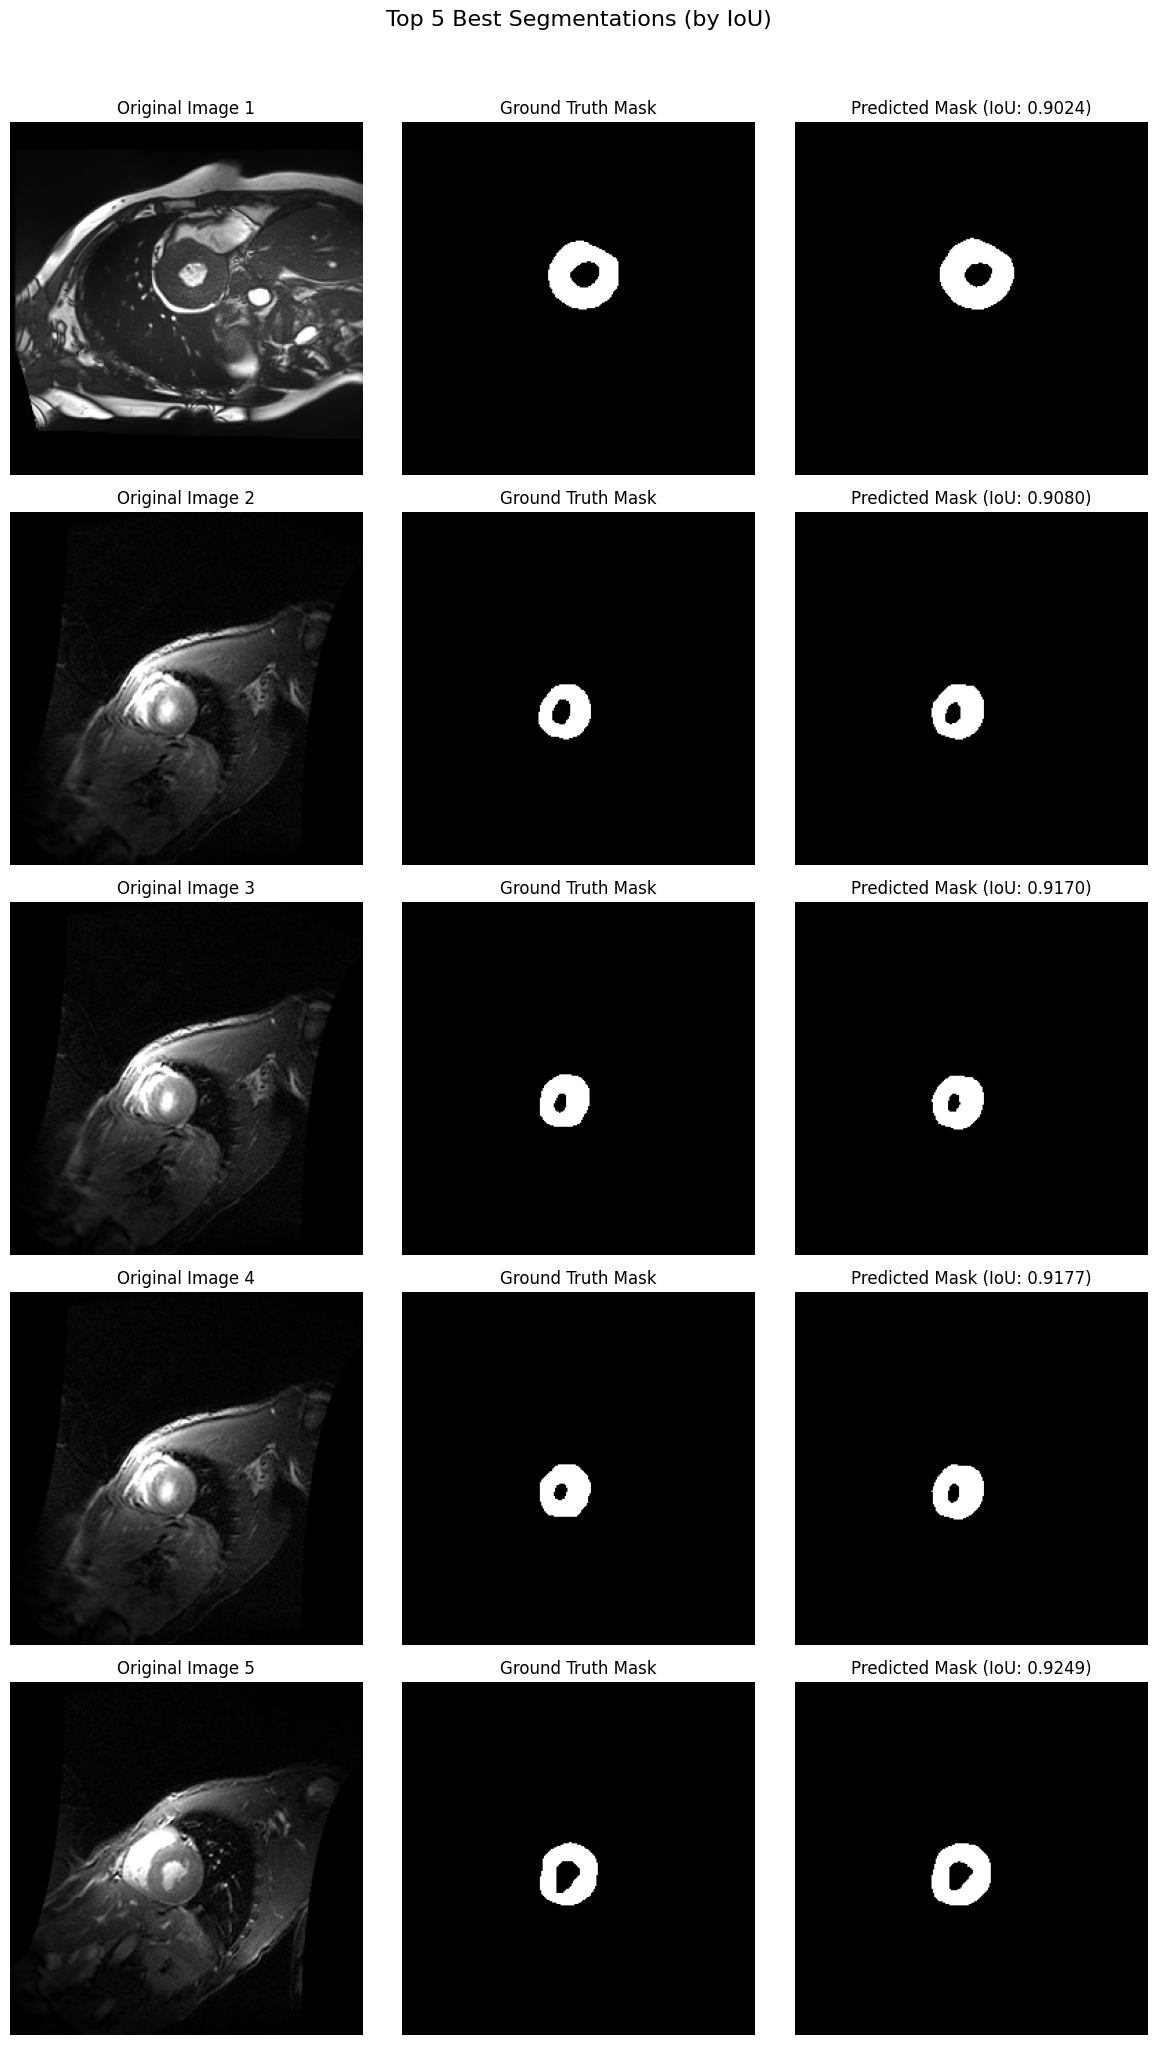

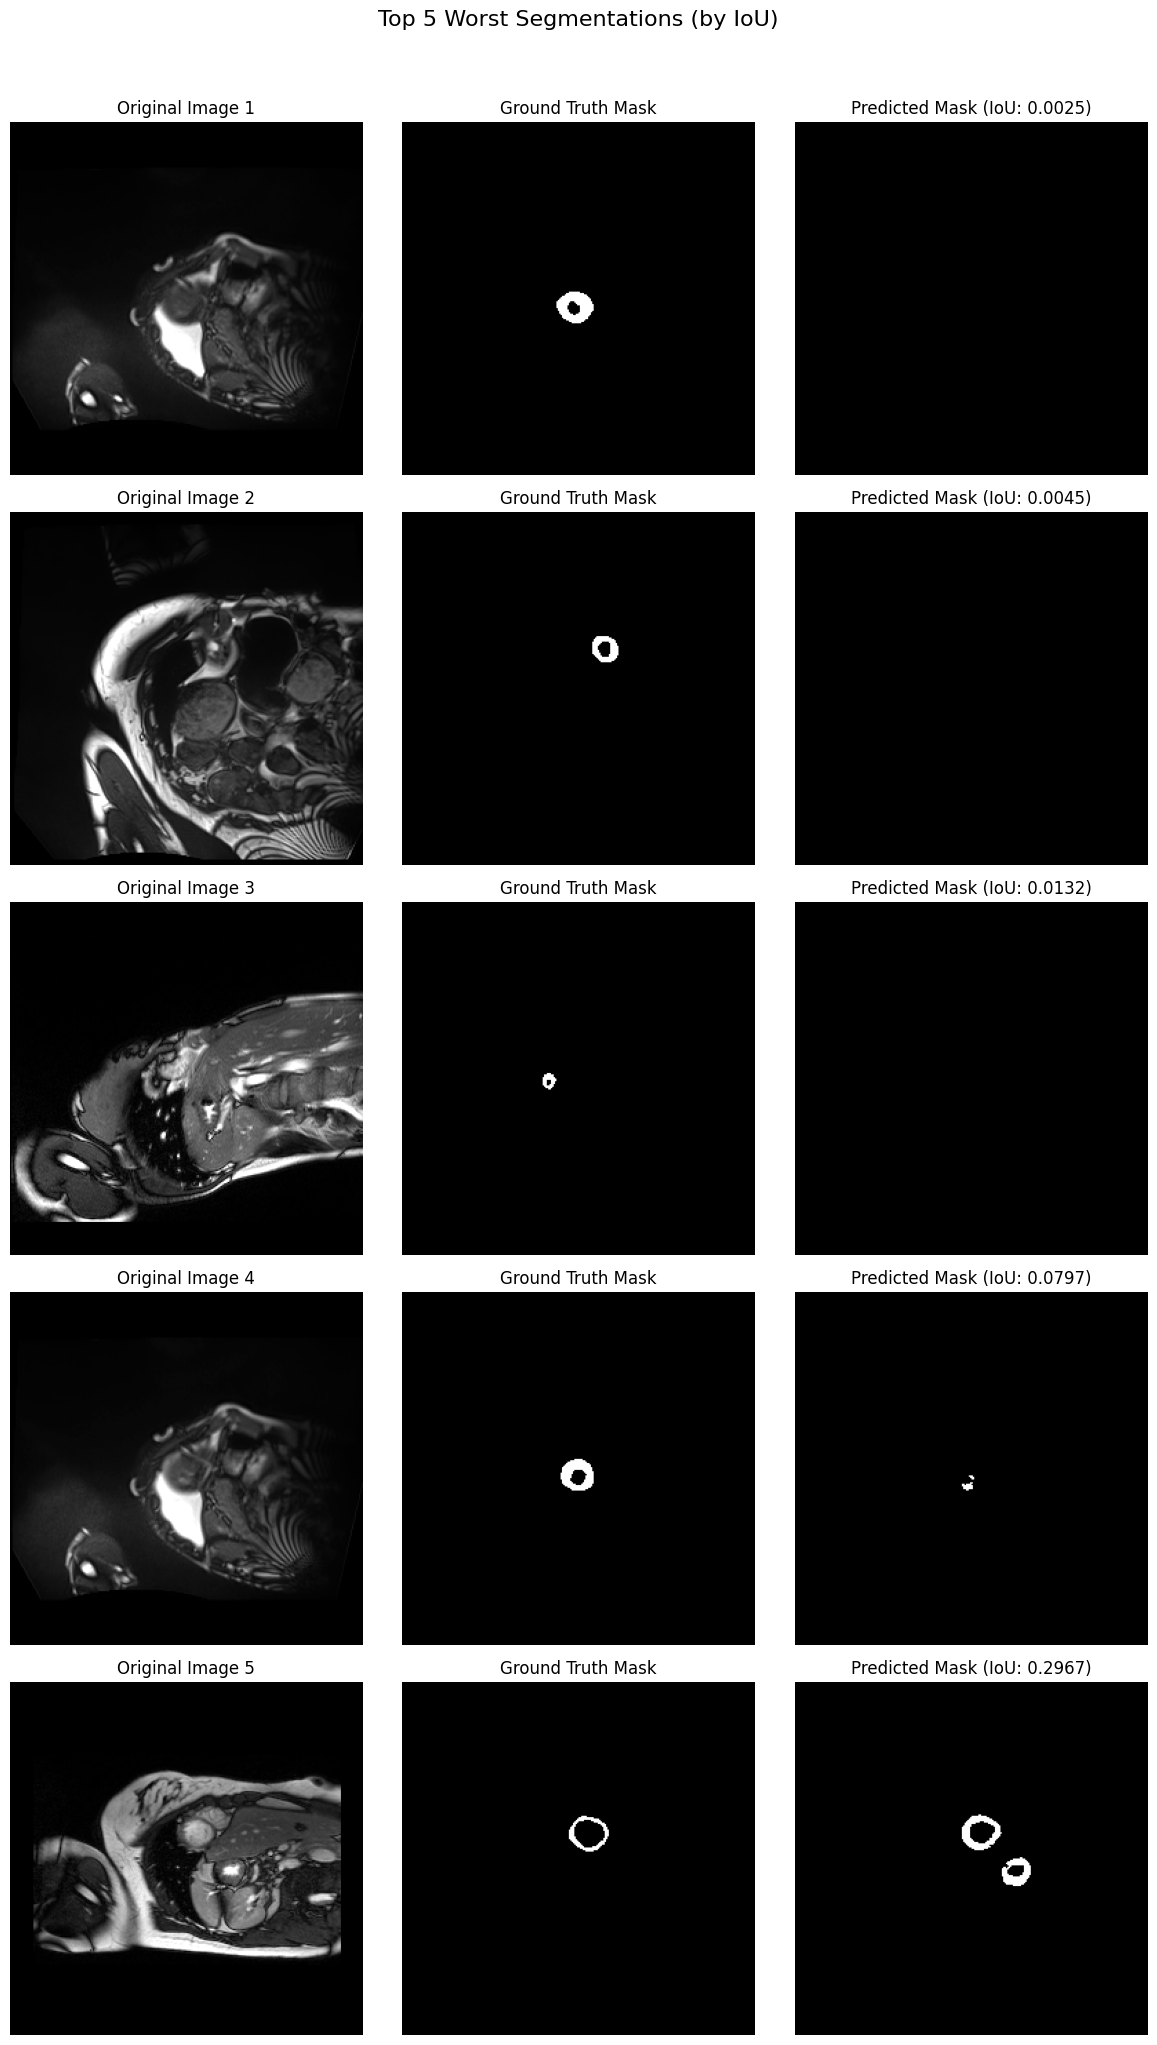

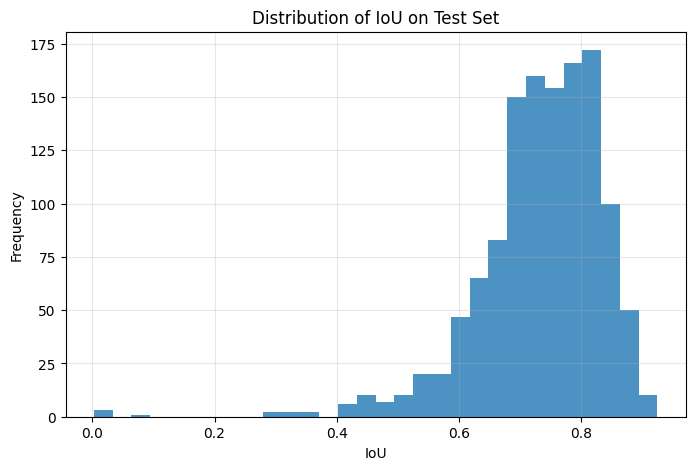

In [ ]:
# 6. Test Set Evaluation

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Helper function to plot samples ---
def plot_samples(images, gt_masks, pred_masks, iou_scores, title):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images) * 4))
    fig.suptitle(title, fontsize=16, y=1.02)

    for i in range(len(images)):
        # Convertir a NumPy
        img = images[i].cpu().numpy().squeeze()
        gt = gt_masks[i].cpu().numpy().squeeze()
        pred = pred_masks[i].cpu().numpy().squeeze()

        # Aplicar Sigmoid y umbral a la predicción
        pred = 1 / (1 + np.exp(-pred))  # Sigmoid
        pred = (pred > 0.5).astype(float)

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask (IoU: {iou_scores[i]:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# --- Create Test Dataset and DataLoader ---
test_dataset = MyocardiumDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- Load the best model ---
model = UnetFunnel(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load('best_unet_funnel_focal.pth', map_location=device))
model.eval()


# --- Store all test results ---
all_test_ious = []
all_images = []
all_gt_masks = []
all_pred_masks = []

print("Running evaluation on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        # El modelo devuelve una sola salida
        outputs = model(images)
        output_final = outputs

        # Calcular IoU por muestra
        for i in range(images.shape[0]):
            img = images[i]
            gt = masks[i]
            pred = output_final[i]

            iou = calculate_iou(pred, gt).item()

            all_test_ious.append(iou)
            all_images.append(img)
            all_gt_masks.append(gt)
            all_pred_masks.append(pred)


# --- Calculate Average IoU ---
avg_test_iou = np.mean(all_test_ious)
print(f"\n--- Average Test IoU: {avg_test_iou:.4f} ---")


# --- Find Best and Worst Samples ---
sorted_indices = np.argsort(all_test_ious)

best_indices = sorted_indices[-5:]
best_images = [all_images[i] for i in best_indices]
best_gts = [all_gt_masks[i] for i in best_indices]
best_preds = [all_pred_masks[i] for i in best_indices]
best_ious = [all_test_ious[i] for i in best_indices]

worst_indices = sorted_indices[:5]
worst_images = [all_images[i] for i in worst_indices]
worst_gts = [all_gt_masks[i] for i in worst_indices]
worst_preds = [all_pred_masks[i] for i in worst_indices]
worst_ious = [all_test_ious[i] for i in worst_indices]


# --- Plot ---
plot_samples(best_images, best_gts, best_preds, best_ious, "Top 5 Best Segmentations (by IoU)")
plot_samples(worst_images, worst_gts, worst_preds, worst_ious, "Top 5 Worst Segmentations (by IoU)")


# Histograma de IoUs
plt.figure(figsize=(8,5))
plt.hist(all_test_ious, bins=30, alpha=0.8)
plt.title("Distribution of IoU on Test Set")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()
